# Solving large linear ODEs with matrix-free operators by Krylov methods

Presented by Chiyoung Ahn (https://github.com/chiyahn)

This notebook demonstrates how Julia `DiffEq` ecosystem can be used to solve large systems of linear ODEs rapidly.

In [ ]:
] add BenchmarkTools Parameters DifferentialEquations IterativeSolvers LinearMaps DiffEqOperators

In [2]:
# NOTE: should use the version e4e8e5419ed29193087130dc004d96e1530a5252 for DiffEqOperators
# (https://github.com/JuliaDiffEq/DiffEqOperators.jl/commit/e4e8e5419ed29193087130dc004d96e1530a5252)
using LinearAlgebra, SparseArrays, Parameters, DifferentialEquations, IterativeSolvers, LinearMaps, DiffEqOperators
using Plots, BenchmarkTools
gr(fmt = :png)

Plots.GRBackend()

## Solving linear ODEs with old school matrix-based operators

Consider a continuous-time Markov chain model on a $N$-dimensional path with large $N$ and the following transition matrix:
$$
Q = 
\begin{pmatrix}
-\theta & \theta & 0 & ... & ...  & ...  & 0 \\
\theta/2 & -\theta & \theta/2 & 0  & \ddots & ...& 0 \\
0 & \theta/2 & -\theta & \theta/2 & 0  & \ddots  & \vdots \\
0 & 0 & \theta/2 & -\theta & \theta/2 & 0 & \vdots \\
\vdots & \ddots & \ddots & \ddots & \ddots  &\ddots  & \vdots \\
0 & ... & ... & ... & 0 & \theta & -\theta
\end{pmatrix}
$$
For instance, for $\theta = 0.5$ with $N = 4$, the chain is
$$
\begin{pmatrix}
-0.5 & 0.5 & 0 & 0 \\
0.25 & -0.5 & 0.25 & 0 \\
0 & 0.25 & -0.5 & 0.25 \\
0 & 0 & 0.5 & -0.5
\end{pmatrix}
$$

For now we assume that $Q$ is time-independent; later in this tutorial we will consider time-variant Markov chain with discrete time steps. The path $f(t)$ associated with $Q$ at $t$ is determined by
$$
f'(t) = Q^T f(t)
$$

Creating a matrix for this particular model is relatively easy:

In [3]:
function get_Q_T_matrix(N, θ) 
    # construct a base matrix
    mat = spdiagm(-1 => fill(θ/2, N-1), 0 => fill(-θ, N), 1 => fill(θ/2, N-1))
    # (1,2) and (N,N-1) elements should be 0.5
    mat[1,2] = θ
    mat[N,(N-1)] = θ
    return mat'
end

# define transition matrix Q
N_small = 4
θ_VAL = 0.5
Q_T = get_Q_T_matrix(N_small, θ_VAL)
display(Matrix(Q_T')) # display Q

4×4 Array{Float64,2}:
 -0.5    0.5    0.0    0.0 
  0.25  -0.5    0.25   0.0 
  0.0    0.25  -0.5    0.25
  0.0    0.0    0.5   -0.5 

so is solving the system:

  154.901 μs (2785 allocations: 281.80 KiB)


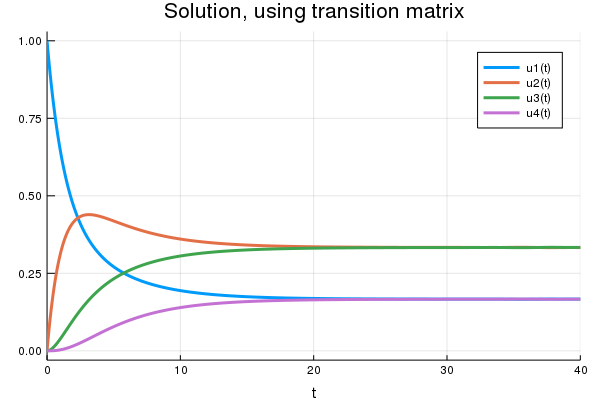

In [4]:
# solve model with matrix Q
function solve_transition_dynamics_matrix()
    # setups
    N = 4
    T = 40.0
    f_0 = [1.0; fill(0.0, N-1)]
    θ = 0.5
    Q_T_matrix = get_Q_T_matrix(N, θ)
    
    # define the corresponding ODE problem
    df(f,p,t) = Q_T_matrix * f
    prob = ODEProblem(df,f_0,(0.0,T),Euler()) # use canonical Euler methods
    
    # solve using a default solver
    solve(prob)
end
sol_matrix = @btime solve_transition_dynamics_matrix()
plot(sol_matrix, title="Solution, using transition matrix")

Even if we have used sparse matrices, once $N$ gets fairly large, retrieving the solution can take a huge amount of time. Consider the following case with $N = 10^6$:

In [5]:
# solve model with matrix Q
function solve_transition_dynamics_matrix_large()
    # setups
    N = 10^6
    T = 40.0
    f_0 = [1.0; fill(0.0, N-1)]
    θ = 0.5
    Q_T_matrix = get_Q_T_matrix(N, θ)
    
    # define the corresponding ODE problem
    df(f,p,t) = Q_T_matrix * f
    prob = ODEProblem(df,f_0,(0.0,T),Euler()) # use canonical Euler methods
    
    # solve using a default solver
    solve(prob)
end
sol_matrix = @btime solve_transition_dynamics_matrix_large();

  8.699 s (3407 allocations: 10.54 GiB)


Certainly doable, but once we have something like $N = 10^8$, computation becomes simply impossible. Even if we set up a matrix in tridiagonal forms, computation gain is not apparent:

In [6]:
function get_Q_T_matrix_tridiag(N, θ) 
    # construct a base matrix
    mat = Tridiagonal(fill(θ/2, N-1), fill(-θ, N), fill(θ/2, N-1))
    # (1,2) and (N,N-1) elements should be 0.5 -- take transpose first
    mat[2,1] = θ
    mat[(N-1),N] = θ
    return mat
end

# solve model with matrix Q
function solve_transition_dynamics_matrix_large_tridiag()
    # setups
    N = 10^6
    T = 40.0
    f_0 = [1.0; fill(0.0, N-1)]
    θ = 0.5
    Q_T_matrix = get_Q_T_matrix_tridiag(N, θ)
    
    # define the corresponding ODE problem
    df(f,p,t) = Q_T_matrix * f
    prob = ODEProblem(df,f_0,(0.0,T),Euler()) # use canonical Euler methods
    
    # solve using a default solver
    solve(prob)
end
@btime solve_transition_dynamics_matrix_large_tridiag();

  8.432 s (3258 allocations: 10.36 GiB)


Note that the sparse matrix tricks we used above can't be applied when the transition matrix is dense due to memory allocation. Also, when we have a complex transition process, writing a transition process in a matrix form can be fairly difficult or undesirable!

## Rapidly solving linear ODEs with matrix-free operators by Krylovin'

Here we show how matrix free operators for $Q^T$ can be defined without relying on a matrix. First, define a function `Q_transpose!` that determines the multiplicative behaviour:

In [7]:
function Q_T!(df, f, p, t)
    @unpack θ, N = p
    df[1] = -θ*f[1]+θ/2*f[2]
    df[N] = θ/2*f[N-1]-θ*f[N]
    Threads.@threads for i = 2:(N-1)
        @inbounds df[i] = θ/2*f[i-1] - θ*f[i] + θ/2*f[i+1]
    end
    df[2] += θ/2*f[1] # from i = 1
    df[N-1] += θ/2*f[N] # from i = N
end

Q_T! (generic function with 1 method)

which is essentially allocating $Q^T f(t)$ into `df` ($f'(t)$). 

Solving the ODE problem with matrix-free operators is fairly similar to the one for matrix based linear ODEs. Once we use Krylov methods, the solution can be readily found in a few seconds.


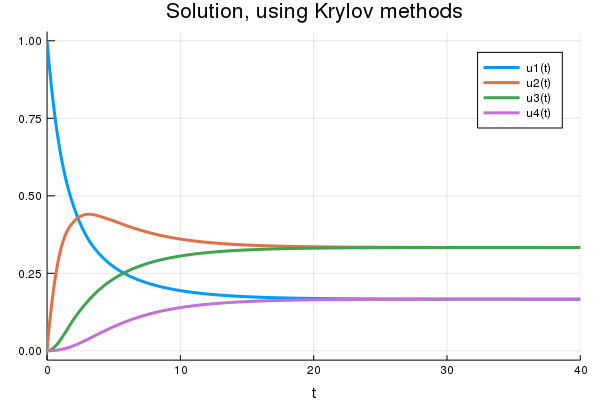

In [8]:
# solve model without matrix
function solve_transition_dynamics()
    # setups
    N = 4
    p = (θ = 0.5, N = N)
    f_0 = [1.0; fill(0.0, p.N-1)]
    O! = MatrixFreeOperator(Q_T!, (p, 0.0), size=(p.N,p.N), opnorm=(p)->1.25)
    t_interpolation=range(0,40.0,length=20)
    
    # define the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,40.0), p)
    # solve using Krylov methods
    solve(prob, LinearExponential(krylov=:simple), tstops=t_interpolation) 
end
sol = solve_transition_dynamics()
plot(sol, title="Solution, using Krylov methods")

Note that we have to provide `tstops` in `solve()`. This `tstops` is not a collection of discrete time step being used; it is rather a collection of sample points for interpolation on the exact solution -- using `LinearExponential` will make `solve()` return an analytic solution using Krylov methods evaluated at `tstops`, and evaluating the returned `sol_krylov` at `t` will provide the solution at `t` by interpolation based on the analytic solution found at `tstops`.

Compare the performance and memory allocation for $N = 10^6$ case:

In [9]:
function solve_transition_dynamics_large()
    # setups
    N = 10^6
    p = (θ = 0.5, N = N)
    f_0 = [1.0; fill(0.0, p.N-1)]
    O! = MatrixFreeOperator(Q_T!, (p, 0.0), size=(p.N,p.N), opnorm=(p)->1.25)
    t_interpolation=range(0,40.0,length=20)
    
    # define the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,40.0), p)
    # solve using Krylov methods
    solve(prob, LinearExponential(krylov=:simple), tstops=t_interpolation) 
end

solve_transition_dynamics_large (generic function with 1 method)

In [10]:
sol_krylov = @btime solve_transition_dynamics_large();

  2.170 s (3894 allocations: 603.22 MiB)


Magnificent! Note that the solution is close to the one computed from a matrix-based operator above (even with $N=10^6$):

In [11]:
norm(sol_matrix.(0:1:40.0) - sol_krylov.(0:1:40.0))

0.21365687364017497

Furthermore, an extreme case with $N = 10^8$ isn't impossible once we reduce the number of nodes:

In [12]:
function solve_transition_dynamics_extreme()
    # setups
    N = 10^8
    p = (θ = 0.5, N = N)
    f_0 = [1.0; fill(0.0, p.N-1)]
    O! = MatrixFreeOperator(Q_T!, (p, 0.0), size=(p.N,p.N), opnorm=(p)->1.25)
    t_interpolation=range(0,40.0,length=20)
    
    # define the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,40.0), p)
    # solve using Krylov methods
    solve(prob, LinearExponential(krylov=:simple), tstops=t_interpolation) 
end

solve_transition_dynamics_extreme (generic function with 1 method)

In [13]:
# run twice to get the accurate computation time after compilation OR use @btime instead
@time solve_transition_dynamics_extreme();

388.059242 seconds (4.40 M allocations: 59.076 GiB, 1.61% gc time)


## Computing stationary distributions

It is well-known that stationary distributions of Markov chains can be computed by finding the normalized eigenvector of the transpose of the transition matrix $Q^T$ associated with the eigenvalue of zero, i.e., finding $v$ such that $Q^T v = 0$. For large systems with complex dynamics, computing the solution can be fairly difficult. 

In Julia, `IterativeSolvers` can be used to find the solution using iterative methods such as conjugate gradient and GMRES. Good news is that, `IterativeSolvers` also supports matrix-free operators too:

In [14]:
N = 10^3

# define parameters for matrix-free operator basis (Q_transpose!)
p = (θ = 0.5, N = N)

# find the stationary distribution (`stationary`)
map_matfree! = LinearMap((y,x) -> Q_T!(y, x, p, 0.0), N; ismutating=true) # defines multiplicative behaviour
stationary, history = @btime cg!(fill(1/N, N), map_matfree!, fill(0.0, N), log = true) # use conjugate gradient
# stationary, history = @time gmres!(fill(1/N, N), map_matfree!, fill(0.0, N), log = true) # enable this line for GMRES
stationary /= sum(stationary) # normalize
stationary;

  1.034 ms (6516 allocations: 181.44 KiB)
